<a href="https://colab.research.google.com/github/EstebanFTellezR/Modelaci-n-y-aja/blob/main/Clasificadores_con_%C3%81rboles_de_Decisi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificadores con Árboles de Decisión

Vamos a crear un modelo de clasificación cuyo objetivo será predecir el Nivel de Confianza (transformación de la variable 'Trust (Government Corruption)') con base en los datos del 2015.

Comenzamos limpiando los datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsr
from scipy.stats import shapiro, spearmanr
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score, explained_variance_score)
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_palette("husl")

data = pd.read_csv(r"C:\Users\Admon\Desktop\2015.csv", delimiter=';')

numeric_cols = ['Happiness Score', 'Standard Error', 'Economy (GDP per Capita)',
                'Family', 'Health (Life Expectancy)', 'Freedom',
                'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']
for col in numeric_cols:
    data[col] = data[col].str.replace(',', '.').astype(float)

print("Valores faltantes por columna:")
print(data.isnull().sum())

data_clean = data.drop(['Country', 'Happiness Rank', 'Standard Error', 'Dystopia Residual'], axis=1)

print("\nInformación del dataset limpio:")
print(data_clean.info())

Valores faltantes por columna:
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

Información del dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Region                         158 non-null    object 
 1   Happiness Score                158 non-null    float64
 2   Economy (GDP per Capita)       158 non-null    float64
 3   Family                         158 non-null    float64
 4   Health (Life Expectancy)       158

In [ ]:
# Creamos las categorías del Nivel de Confianza, con base en la variable 'Trust (Government Corruption)'
data_clean['Nivel_Confianza'] = pd.cut(data_clean['Trust (Government Corruption)'],
                                bins=[-0.1, 0.1, 0.3, 1],
                                labels=['Baja (0-0.1)', 'Media (0.1-0.3)', 'Alta (0.3-1)'])

print(data_clean['Nivel_Confianza'].value_counts(normalize=True)*100)

Nivel_Confianza
Baja (0-0.1)       46.202532
Media (0.1-0.3)    39.240506
Alta (0.3-1)       14.556962
Name: proportion, dtype: float64


Vamos a imprimir la distribución de felicidad por nivel de confianza gubernamental. Para ello vamos a crear un boxplot que compare la distribución del Happiness Score entre los niveles de confianza que acabamos de crear.

Podemos observar que a mayor nivel de confianza en el gobierno, mayor tiende a ser el nivel de felicidad:

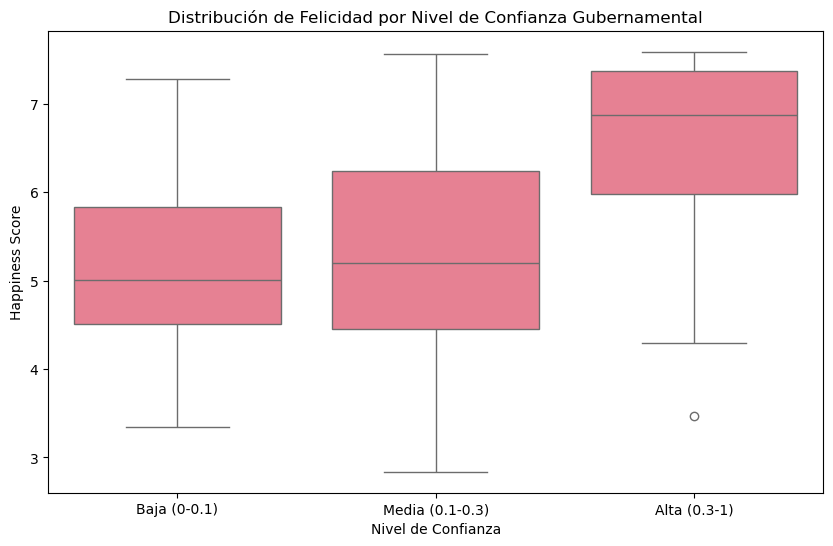

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Nivel_Confianza', y='Happiness Score', data=data_clean, order=['Baja (0-0.1)', 'Media (0.1-0.3)', 'Alta (0.3-1)'])
plt.title('Distribución de Felicidad por Nivel de Confianza Gubernamental')
plt.xlabel('Nivel de Confianza')
plt.ylabel('Happiness Score')
plt.show()

Ahora, vamos a crear un mapa de calor para ver cómo se relacionan las variables con esos niveles de confianza que creamos.

Para entender este mapa, los valores que aparecen son los promedios de cada variable por nivel de confianza.

Podemos observar que los países que tienen un nivel de confianza alto, tienen mayor GDP (PIB), apoyo familiar, esperazna de vida y percepción de libertad. Y por otro lado, refuerza la conclusión del gráfico anterior:

C:\Users\Admon\AppData\Local\Temp\ipykernel_4844\3991654091.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confianza_features = data_clean.groupby('Nivel_Confianza')[['Economy (GDP per Capita)', 'Family',


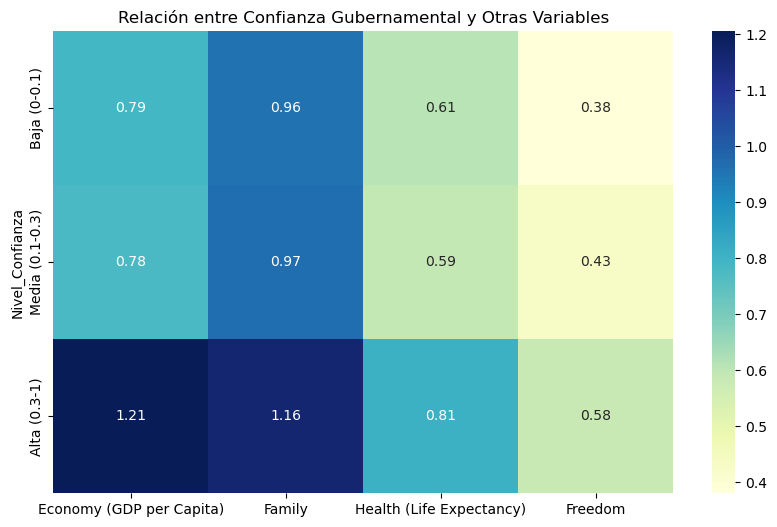

In [ ]:
confianza_features = data_clean.groupby('Nivel_Confianza')[['Economy (GDP per Capita)', 'Family',
                                                     'Health (Life Expectancy)', 'Freedom']].mean()

plt.figure(figsize=(10,6))
sns.heatmap(confianza_features, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Relación entre Confianza Gubernamental y Otras Variables')
plt.show()

También podemos observar la distribución del nivel de confianza por región:

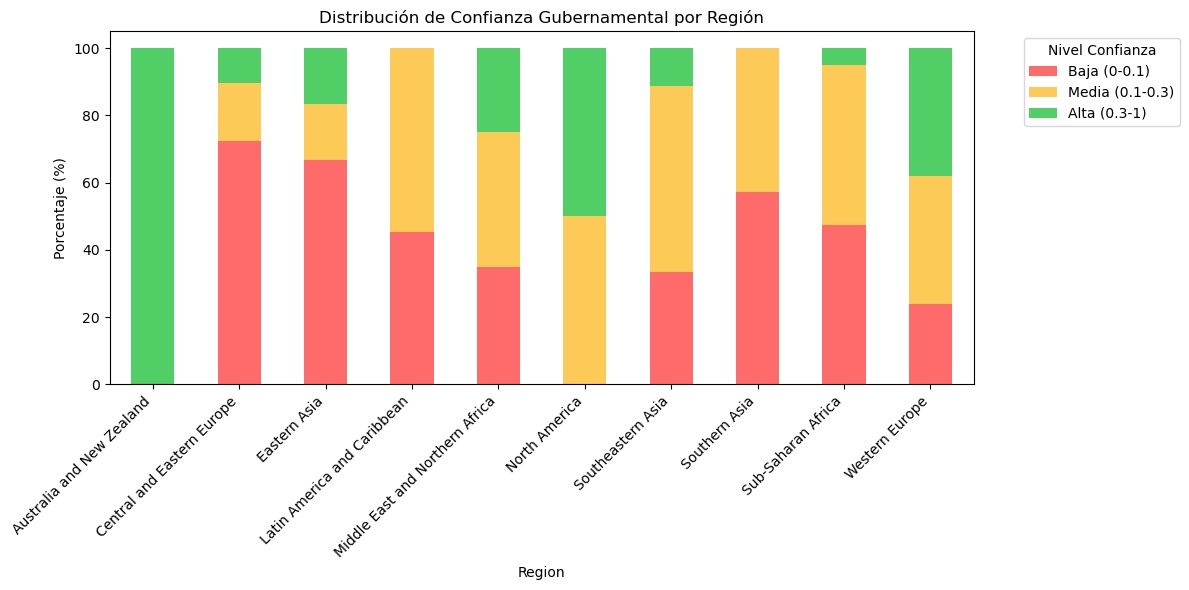

In [ ]:
confianza_region = pd.crosstab(data_clean['Region'], data_clean['Nivel_Confianza'], normalize='index')*100

confianza_region.plot(kind='bar', stacked=True,
                     color=['#ff6b6b','#feca57','#51cf66'],
                     figsize=(12,6))
plt.title('Distribución de Confianza Gubernamental por Región')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nivel Confianza', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Vamos a crear nuestro árbol, eligiendo la variable a predecir como el nivel de confianza, basado en las demás variables.

Distribución en y_train:
 Nivel_Confianza
Baja (0-0.1)       0.460317
Media (0.1-0.3)    0.396825
Alta (0.3-1)       0.142857
Name: proportion, dtype: float64

Distribución en y_test:
 Nivel_Confianza
Baja (0-0.1)       0.46875
Media (0.1-0.3)    0.37500
Alta (0.3-1)       0.15625
Name: proportion, dtype: float64


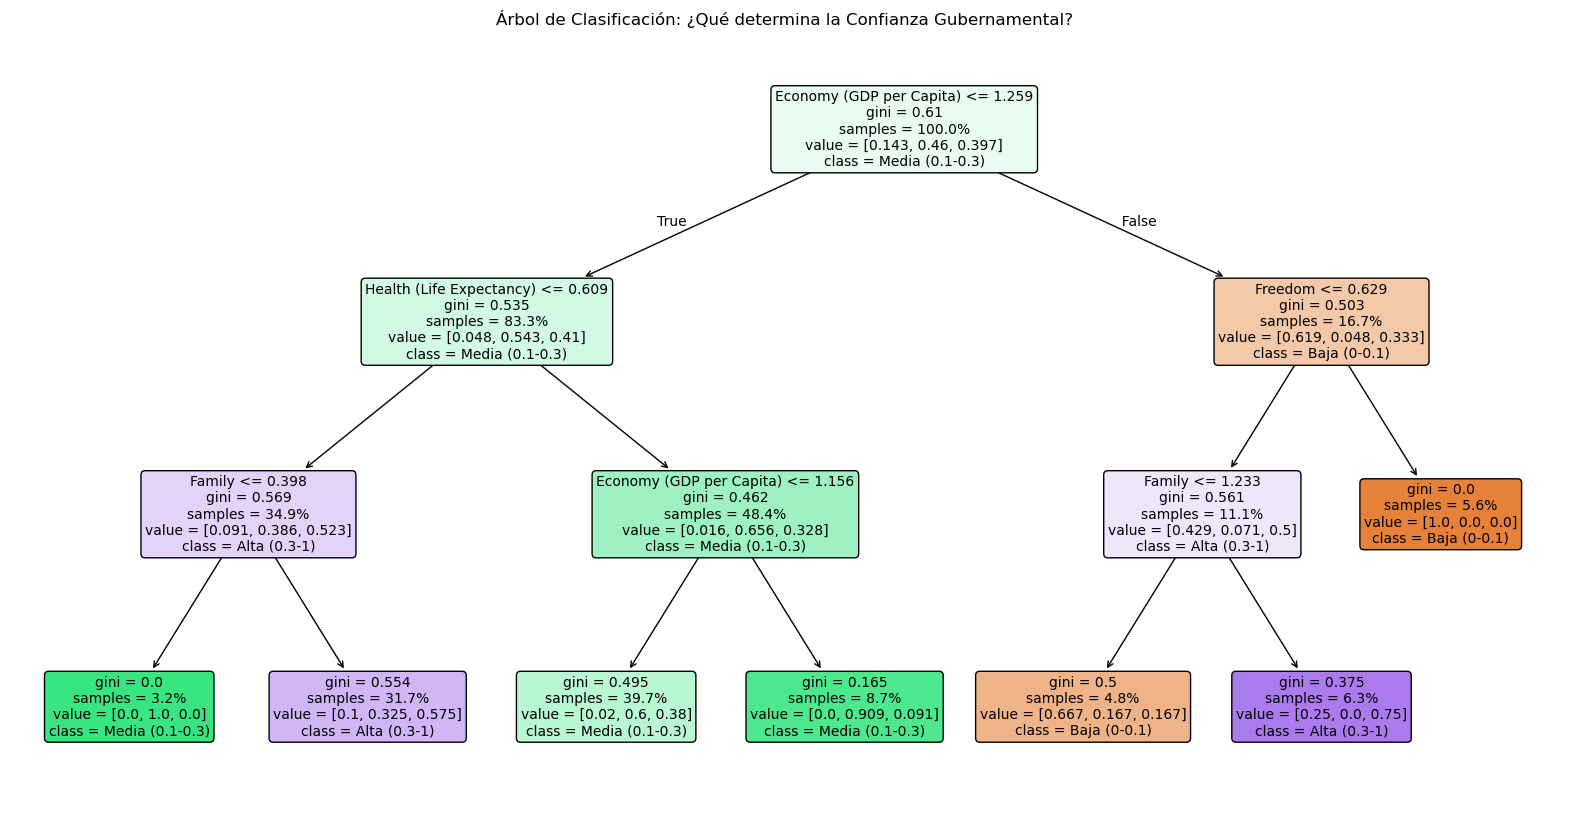

In [ ]:
# Elegimos las variables para el modelo
X = data_clean[['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom']]
y = data_clean['Nivel_Confianza']

# Dividimos por datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)  # Mantiene proporción de clases

print("Distribución en y_train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en y_test:\n", y_test.value_counts(normalize=True))

# Entrenamos el modelo modelo
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predecimos
y_pred = model.predict(X_test)

# Visualizamos el árbol
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=y.cat.categories,
          filled=True, rounded=True, proportion=True, fontsize=10)
plt.title('Árbol de Clasificación: ¿Qué determina la Confianza Gubernamental?')
plt.show()

Tomemos unos datos al azar de dos países para predecir su nivel de confianza:

- País 1:

'Economy (GDP per Capita)'=1.25, 'Family'=1.4, 'Health (Life Expectancy)'=0.9, 'Freedom'=0.6

- País 2:

'Economy (GDP per Capita)'=0.5, 'Family'=0.3, 'Health (Life Expectancy)'=0.4, 'Freedom'=0.2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

X_ejemplo = np.array([[1.25, 1.4, 0.9, 0.6],   # País 1
                      [0.5, 0.3, 0.4, 0.2]])   # País 2

modelo_confianza = DecisionTreeClassifier()
predicciones = model.predict(X_ejemplo)

print("Predicciones:", predicciones)

Predicciones: ['Baja (0-0.1)' 'Baja (0-0.1)']


C:\Users\Admon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Podemos analizar el rendimiento del modelo utilizando varias métricas. Una de ellas es la matriz de confusión:

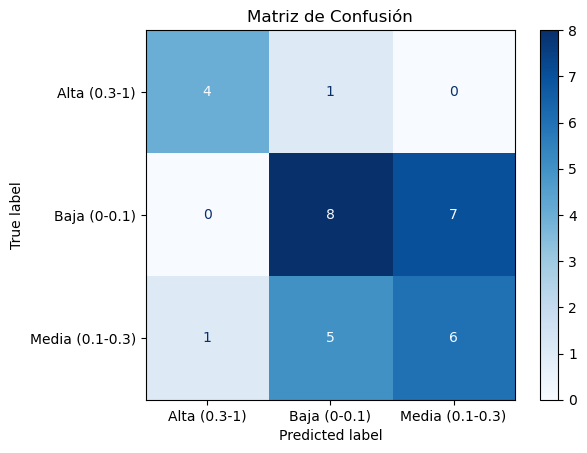

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = y_test
y_pred = model.predict(X_test)

cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

El modelo predice bien el nivel Alto (100% de aciertos). Tiene algunas confusiones entre los niveles “Medio” y “Bajo”.

Otra métrica es el Reporte Clasificación:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Baja', 'Media', 'Alta']))

              precision    recall  f1-score   support

        Baja       0.80      0.80      0.80         5
       Media       0.57      0.53      0.55        15
        Alta       0.46      0.50      0.48        12

    accuracy                           0.56        32
   macro avg       0.61      0.61      0.61        32
weighted avg       0.57      0.56      0.56        32



De allí, podemos observar que la:

- Clase "Baja" fue clasificada perfectamente: precision, recall y F1 = 1.00.

- Clase "Media" tiene un buen balance, aunque bajó un poco: F1 = 0.69.

- Clase "Alta" fue la más difícil: F1 = 0.64-

En términos de accuracy (exactitud), vemos que 72% de las predicciones totales fueron correctas. En general, esta métrica nos dice que el modelo tiene un buen rendimiento y especialmente, es bueno prediciendo la clase Baja.

Por último, veamos la Curva ROC y AUC, que evalúa el rendimiento del modelo en clasificación para cada clase individual, y nos da una idea de qué tan bien el modelo separa las clases:

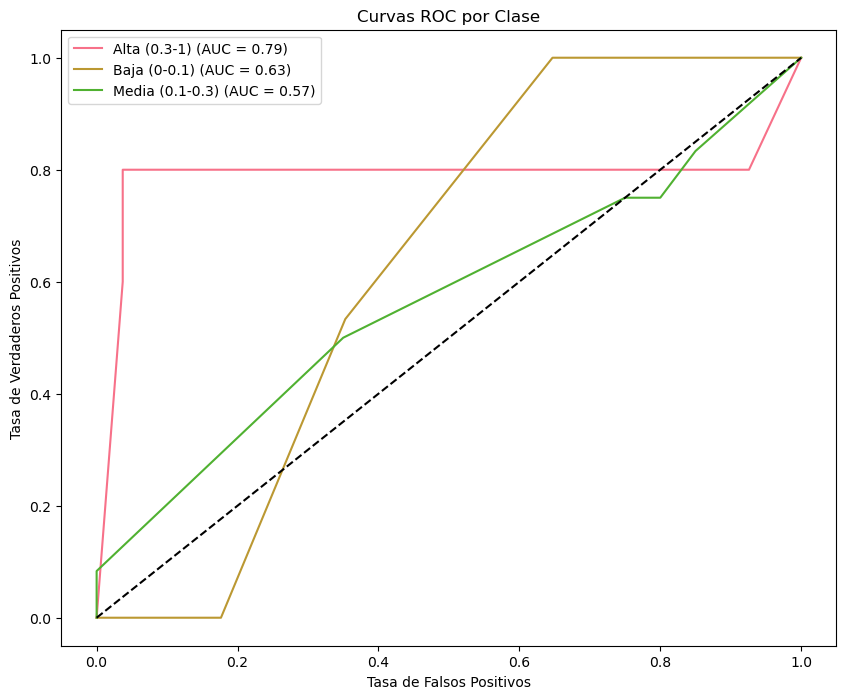

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=model.classes_)
y_pred_bin = model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(len(model.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend()
plt.show()

En este caso, la mejor clase detectada fue Alta, seguida por Baja, y la más confusa fue Media.

Podría ser contradictorio el hecho de que esta métrica dice que la mejor clase detectada fue la Alta y en la métrica anterior fue la Baja, pero realmente no es así, porque el F1 mide el desempeño del clasificador en una clase específica, considerando predicciones concretas y la curva AUC-ROC mide qué tan separables son las clases.

En nuestro caso, el modelo está clasificando muy bien la clase "Baja" con el umbral actual; pero, tiene mejor capacidad para detectar la clase "Alta" si se ajustara el umbral o se tomaran decisiones basadas en probabilidad.

- Reflexión: Esto implica que dependiendo qué quiero saber yo del rendimiento del modelo, así mismo usaré las métricas. Si queremos saber qué tan bien el modelo está clasificando actualmente, sería un error basarse en la curva AUC-ROC, en este caso analizaríamos el F1, sin embargo, si queremos evaluar el potencial del modelo para distinguir una clase de las demás, la curva AUC-ROC sería la métrica adecuada.